Validation of the cutset conditioning algorithm: using the light model, compare my won implementation for 3 days against the variable elimination algorithm from the library. Both are exact inference algorithms, they should give the exact same results.

My won implementation: model with FEV1 noise, and temporal airway resistance

In [1]:
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots

import src.data.breathe_data as bd
import src.data.helpers as dh
import src.inference.helpers as ih
import src.modelling_ar.ar as ar
import src.inf_cutset_conditioning.helpers as cutseth
import src.inf_cutset_conditioning.cutset_cond_algs as cca
import src.inf_cutset_conditioning.cutset_cond_algs_learn_ar_change as cca_ar_change

import src.models.builders as mb
import src.models.var_builders as var_builders
from pgmpy.inference.ExactInference import VariableElimination
from pgmpy.factors.discrete import TabularCPD

import networkx as nx

In [2]:
# Made up data
df_mock = pd.DataFrame(
    {
        "ID": ["1", "1", "1"],
        "Date Recorded": [1, 2, 3],
        "Height": 180,
        "Age": 35,
        "Sex": "Male",
        "ecFEV1": [1.8, 2.2, 2.2],
        "ecFEF2575%ecFEV1": [12, 120, 150],
        "idx ecFEV1 (L)": [1, 2, 2],
        "idx ecFEF2575%ecFEV1": [0, 6, 7],
        "idx ecFEF25-75 % ecFEV1 (%)": [0, 6, 7],
    }
)

# df_mock = pd.DataFrame(
#     {
#         "ID": ["1", "1"],
#         "Date Recorded": [1, 2],
#         "Height": 180,
#         "Age": 35,
#         "Sex": "Male",
#         "ecFEV1": [1.8, 3.2],
#         "ecFEF2575%ecFEV1": [12, 120],
#         "idx ecFEV1 (L)": [1, 3],
#         "idx ecFEF2575%ecFEV1": [0, 6],
#     }
# )

# df_mock = pd.DataFrame(
#     {
#         "ID": ["1"],
#         "Date Recorded": [1],
#         "Height": 180,
#         "Age": 35,
#         "Sex": "Male",
#         "ecFEV1": [1.8],
#         "ecFEF2575%ecFEV1": [12],
#         "idx ecFEV1 (L)": [1],
#         "idx ecFEF2575%ecFEV1": [0],
#     }
# )
df_mock["Date Recorded"] = pd.to_datetime(
    df_mock["Date Recorded"], unit="D", origin="2020-01-01"
)
df_mock

,ID,Date Recorded,Height,Age,Sex,ecFEV1,ecFEF2575%ecFEV1,idx ecFEV1 (L),idx ecFEF2575%ecFEV1,idx ecFEF25-75 % ecFEV1 (%)
0,1,2020-01-02,180,35,Male,1.8,12,1,0,0
1,1,2020-01-03,180,35,Male,2.2,120,2,6,6
2,1,2020-01-04,180,35,Male,2.2,150,2,7,7


# Without temporal connections

In [15]:
height = 180
age = 35
sex = "Male"
(
    HFEV1,
    uecFEV1,
    ecFEV1,
    AR,
    HO2Sat,
    O2SatFFA,
    IA,
    UO2Sat,
    O2Sat,
    ecFEF2575prctecFEV1,
) = var_builders.o2sat_fev1_fef2575_point_in_time_model_noise_shared_healthy_vars_light(
    height,
    age,
    sex,
)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/tristan.trebaol/Desktop/PhD/Code/phd//src/models/cpts/ecFEV1_0_6_1_uecFEV1_0_6_1_std_add_mult.npy'

## Variable elimination

In [4]:
height = 180
age = 35
sex = "Male"
(
    model,
    # inf_alg,
    HFEV1,
    HO2Sat,
    AR_vars,
    uecFEV1_vars,
    ecFEV1_vars,
    O2SatFFA_vars,
    IA_vars,
    UO2Sat_vars,
    O2Sat_vars,
    ecFEF2575prctecFEV1_vars,
) = mb.o2sat_fev1_fef2575_n_days_model_noise_shared_healthy_vars_light(
    3,
    height,
    age,
    sex,
)
var_elim = VariableElimination(model)

evidence_dict = {}
for i in range(3):
    evidence_dict[ecFEV1_vars[i].name] = df_mock.loc[i, "idx ecFEV1 (L)"]
    evidence_dict[ecFEF2575prctecFEV1_vars[i].name] = df_mock.loc[
        i, "idx ecFEF2575%ecFEV1"
    ]
print(evidence_dict)

res_ve = var_elim.query(
    variables=[AR_vars[0].name, AR_vars[1].name, AR_vars[2].name, HFEV1.name],
    evidence=evidence_dict,
    joint=False,
)
res_ve[AR_vars[1].name].values

KeyError: 2

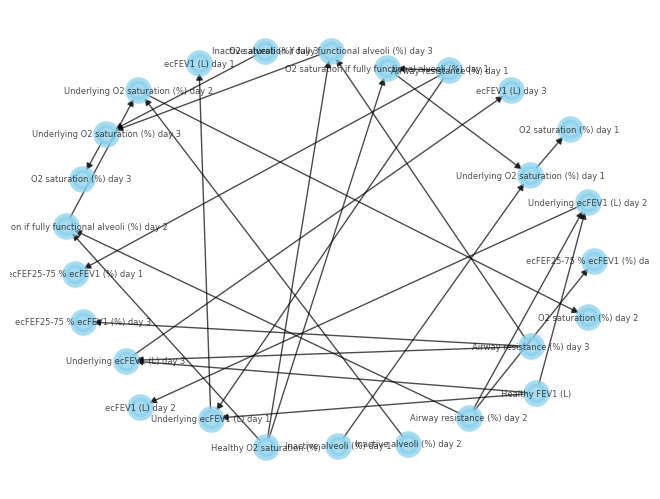

In [21]:
# Create a directed graph from the model edges
nx_graph = nx.DiGraph(model.edges())

# Use spring layout for better spacing between nodes
pos = nx.spring_layout(nx_graph, k=10)  # Adjust k for more/less space between nodes

# Draw the graph with specified layout and font size
nx.draw(
    nx_graph,
    pos,
    with_labels=True,
    node_size=200,
    node_color="skyblue",
    # node_shape="o",
    alpha=0.7,
    linewidths=5,
    font_size=6,  # Reduce font size for node labels
)

#### VE for 1 day

In [4]:
height = 180
age = 35
sex = "Male"
(
    model,
    # inf_alg,
    HFEV1,
    HO2Sat,
    AR_vars,
    uecFEV1_vars,
    ecFEV1_vars,
    O2SatFFA_vars,
    IA_vars,
    UO2Sat_vars,
    O2Sat_vars,
    ecFEF2575prctecFEV1_vars,
) = mb.o2sat_fev1_fef2575_n_days_model_noise_shared_healthy_vars_light(
    2,
    height,
    age,
    sex,
)
var_elim = VariableElimination(model)

evidence_dict = {}
for i in range(2):
    evidence_dict[ecFEV1_vars[i].name] = df_mock.loc[i, "idx ecFEV1 (L)"]
    evidence_dict[ecFEF2575prctecFEV1_vars[i].name] = df_mock.loc[
        i, "idx ecFEF2575%ecFEV1"
    ]
print(evidence_dict)

res_ve = var_elim.query(
    variables=[AR_vars[0].name, HFEV1.name],
    evidence=evidence_dict,
    joint=False,
)
res_ve[AR_vars[0].name].values

{'ecFEV1 (L) day 1': 1, 'ecFEF25-75 % ecFEV1 (%) day 1': 0}


array([0.00041647, 0.00409604, 0.02342945, 0.13116375, 0.22127429,
       0.13424208, 0.15825992, 0.20114615, 0.12597185])

## Cutset conditioning

In [18]:
fig, p_M_given_D, AR_dist_given_M_matrix = (
    cca.compute_log_p_D_given_M_for_noise_model_light(df_mock, ar_prior="uniform")
)

Processing ID 1
ID 1


In [20]:
fig = make_subplots(rows=4, cols=1, vertical_spacing=0.13)
# Add HFEV1
ih.plot_histogram(
    fig, HFEV1, res_ve[HFEV1.name].values, HFEV1.a, HFEV1.b, 1, 1, annot=False
)
ih.plot_histogram(
    fig, AR, res_ve[AR_vars[0].name].values, AR.a, AR.b, 2, 1, annot=False
)
ih.plot_histogram(
    fig, AR, res_ve[AR_vars[1].name].values, AR.a, AR.b, 3, 1, annot=False
)
ih.plot_histogram(
    fig, AR, res_ve[AR_vars[2].name].values, AR.a, AR.b, 4, 1, annot=False
)

# Add HFEV1
ih.plot_histogram(fig, HFEV1, p_M_given_D, HFEV1.a, HFEV1.b, 1, 1, title=HFEV1.name)
ih.plot_histogram(
    fig,
    AR,
    AR_dist_given_M_matrix[0, :],
    AR.a,
    AR.b,
    2,
    1,
    title=f"{AR.name} day 1",
    annot=False,
)
ih.plot_histogram(
    fig,
    AR,
    AR_dist_given_M_matrix[1, :],
    AR.a,
    AR.b,
    3,
    1,
    title=f"{AR.name} day 2",
    annot=False,
)
ih.plot_histogram(
    fig,
    AR,
    AR_dist_given_M_matrix[2, :],
    AR.a,
    AR.b,
    4,
    1,
    title=f"{AR.name} day 3",
    annot=False,
)

for i in range(4):
    fig.data[i].marker.color = "#636EFA"
    fig.data[i + 4].marker.color = "#EF553B"
# Reduce x axis title font size
fig.update_xaxes(title_font=dict(size=12), title_standoff=7)

# Hide legend
title = "Cutset conditioning (red) vs variable elimination (blue)"
fig.update_layout(showlegend=False, height=550, width=800, title=title)
fig.show()

#### Validate the custet cond works for one day input

In [18]:
# ONE DAY
fig = make_subplots(rows=2, cols=1, vertical_spacing=0.13)
# Add HFEV1
ih.plot_histogram(
    fig, HFEV1, res_ve[HFEV1.name].values, HFEV1.a, HFEV1.b, 1, 1, annot=False
)
ih.plot_histogram(
    fig, AR, res_ve[AR_vars[0].name].values, AR.a, AR.b, 2, 1, annot=False
)

# Add HFEV1
ih.plot_histogram(fig, HFEV1, p_M_given_D, HFEV1.a, HFEV1.b, 1, 1, title=HFEV1.name)
ih.plot_histogram(
    fig,
    AR,
    AR_dist_given_M_matrix[0, :],
    AR.a,
    AR.b,
    2,
    1,
    title=f"{AR.name} day 1",
    annot=False,
)

for i in range(2):
    fig.data[i].marker.color = "#636EFA"
    fig.data[i + 2].marker.color = "#EF553B"
# Reduce x axis title font size
fig.update_xaxes(title_font=dict(size=12), title_standoff=7)

# Hide legend
title = "Cutset conditioning (red) vs variable elimination (blue)"
fig.update_layout(showlegend=False, height=550, width=800, title=title)
fig.show()

#### Validate the point mass HFEV1 prior works

In [ ]:
# Updated var_builders with point mass HFEV1

# HFEV1 = SharedVariableNode("Healthy FEV1 (L)", 1, 6, 1, prior=hfev1_prior)
# HFEV1_point_mass_prior = np.zeros(HFEV1.card)
# idx_three_point_five = HFEV1.get_bin_for_value(3.5)[1]
# HFEV1_point_mass_prior[idx_three_point_five] = 1
# HFEV1.cpt = HFEV1.set_prior({"type": "custom", "p": HFEV1_point_mass_prior})

In [14]:
# POINT MASS HFEV1 FOR ONE DAY
fig = make_subplots(rows=2, cols=1, vertical_spacing=0.13)
# Add HFEV1
ih.plot_histogram(
    fig, HFEV1, res_ve[HFEV1.name].values, HFEV1.a, HFEV1.b, 1, 1, annot=False
)
ih.plot_histogram(
    fig, AR, res_ve[AR_vars[0].name].values, AR.a, AR.b, 2, 1, annot=False
)

# Add HFEV1
ih.plot_histogram(fig, HFEV1, p_M_given_D, HFEV1.a, HFEV1.b, 1, 1, title=HFEV1.name)
ih.plot_histogram(
    fig,
    AR,
    AR_dist_given_M_matrix[0, :],
    AR.a,
    AR.b,
    2,
    1,
    title=f"{AR.name} day 1",
    annot=False,
)

for i in range(2):
    fig.data[i].marker.color = "#636EFA"
    fig.data[i + 2].marker.color = "#EF553B"
# Reduce x axis title font size
fig.update_xaxes(title_font=dict(size=12), title_standoff=7)

# Hide legend
title = "Cutset conditioning (red) vs variable elimination (blue)"
fig.update_layout(showlegend=False, height=550, width=800, title=title)
fig.show()

#### Validate that custom BP implementation works

In [9]:
# COMPARING CUSTOM BP ON POINT IN TIME MODEL AGAINST VE

(
    model,
    inf_alg,
    HFEV1,
    uecFEV1,
    ecFEV1,
    AR,
    HO2Sat,
    O2SatFFA,
    IA,
    uO2Sat,
    O2Sat,
    ecFEF2575prctecFEV1,
) = mb.o2sat_fev1_fef2575_point_in_time_model_noise_shared_healthy_vars_light(
    height, age, sex
)

res_bp = ih.infer_on_factor_graph(
    inf_alg,
    [HFEV1, AR],
    [
        [ecFEV1, df_mock.loc[0, "idx ecFEV1 (L)"]],
        [ecFEF2575prctecFEV1, df_mock.loc[0, "idx ecFEF2575%ecFEV1"]],
    ],
)

In [10]:
# POINT MASS HFEV1
fig = make_subplots(rows=2, cols=1, vertical_spacing=0.13)
# Add HFEV1
ih.plot_histogram(
    fig, HFEV1, res_ve[HFEV1.name].values, HFEV1.a, HFEV1.b, 1, 1, annot=False
)
ih.plot_histogram(
    fig, AR, res_ve[AR_vars[0].name].values, AR.a, AR.b, 2, 1, annot=False
)

# Add HFEV1
ih.plot_histogram(
    fig, HFEV1, res_bp[HFEV1.name].values, HFEV1.a, HFEV1.b, 1, 1, title=HFEV1.name
)
ih.plot_histogram(
    fig,
    AR,
    res_bp[AR.name].values,
    AR.a,
    AR.b,
    2,
    1,
    title=f"{AR.name} day 1",
    annot=False,
)

for i in range(2):
    fig.data[i].marker.color = "#636EFA"
    fig.data[i + 2].marker.color = "#EF553B"
# Reduce x axis title font size
fig.update_xaxes(title_font=dict(size=12), title_standoff=7)

# Hide legend
title = "Cutset conditioning (red) vs variable elimination (blue)"
fig.update_layout(showlegend=False, height=550, width=800, title=title)
fig.show()

# With temporal connections

In [3]:
height = 180
age = 35
sex = "Male"
(
    HFEV1,
    uecFEV1,
    ecFEV1,
    AR,
    HO2Sat,
    O2SatFFA,
    IA,
    UO2Sat,
    O2Sat,
    ecFEF2575prctecFEV1,
) = var_builders.o2sat_fev1_fef2575_long_model_noise_shared_healthy_vars_and_temporal_ar_light(
    height,
    age,
    sex,
)

df_mock

,ID,Date Recorded,Height,Age,Sex,ecFEV1,ecFEF2575%ecFEV1,idx ecFEV1 (L),idx ecFEF2575%ecFEV1
0,1,2020-01-02,180,35,Male,1.8,12,1,0
1,1,2020-01-03,180,35,Male,2.2,120,2,6
2,1,2020-01-04,180,35,Male,2.2,150,2,7


## Run Variable Elimination

In [7]:
height = 180
age = 35
sex = "Male"
n_days = 3
(
    model,
    # inf_alg,
    HFEV1,
    HO2Sat,
    AR_vars,
    uecFEV1_vars,
    ecFEV1_vars,
    O2SatFFA_vars,
    IA_vars,
    UO2Sat_vars,
    O2Sat_vars,
    ecFEF2575prctecFEV1_vars,
) = mb.o2sat_fev1_fef2575_n_days_model_noise_shared_healthy_vars_and_temporal_ar_light(
    n_days,
    height,
    age,
    sex,
    ar_change_cpt_state=-1
)
var_elim = VariableElimination(model)

evidence_dict = {}
for i in range(n_days):
    evidence_dict[ecFEV1_vars[i].name] = df_mock.loc[i, "idx ecFEV1 (L)"]
    evidence_dict[ecFEF2575prctecFEV1_vars[i].name] = df_mock.loc[
        i, "idx ecFEF2575%ecFEV1"
    ]

# evidence_dict[ecFEV1_vars[1].name] = df_mock.loc[1, "idx ecFEV1 (L)"]
print(evidence_dict)

# ar_ve_from_day_1_CPD = TabularCPD(
#     AR_vars[1].name, AR_vars[1].card, ar_ve_from_day_1.reshape(-1, 1)
# )

res_ve = var_elim.query(
    # variables=[AR_vars[0].name, AR_vars[1].name, HFEV1.name],
    variables=[AR_vars[0].name, AR_vars[1].name, AR_vars[2].name, HFEV1.name],
    evidence=evidence_dict,
    joint=False,
    # virtual_evidence=[ar_ve_from_day_1_CPD]
)
res_ve[AR_vars[1].name].values

Airway resistance (%) day 2, cpt: (9, 9)
Airway resistance (%) day 3, cpt: (9, 9)
{'ecFEV1 (L) day 1': 1, 'ecFEF25-75 % ecFEV1 (%) day 1': 0, 'ecFEV1 (L) day 2': 2, 'ecFEF25-75 % ecFEV1 (%) day 2': 6, 'ecFEV1 (L) day 3': 2, 'ecFEF25-75 % ecFEV1 (%) day 3': 7}


array([1.24595369e-01, 3.81198670e-01, 3.92404447e-01, 9.94358690e-02,
       2.36508481e-03, 5.59508668e-07, 1.81217508e-10, 2.01191596e-13,
       3.35771749e-15])

In [ ]:
ar_day_2_VE = np.array(
    [
        0.12656231,
        0.2060752,
        0.21464146,
        0.22984097,
        0.15453915,
        0.03375353,
        0.03064757,
        0.00393981,
        0.0,
    ]
)
ar_day_1_VE = np.array(
    [
        0.10289117,
        0.20334571,
        0.22836516,
        0.21025736,
        0.1657572,
        0.05405213,
        0.02963171,
        0.00527891,
        0.00042065,
    ]
)

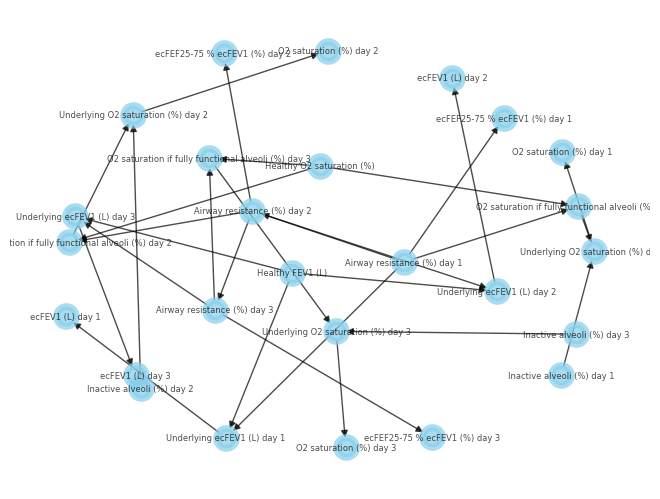

In [42]:
import networkx as nx

# Create a directed graph from the model edges
nx_graph = nx.DiGraph(model.edges())

# Use spring layout for better spacing between nodes
pos = nx.spring_layout(nx_graph, k=1)  # Adjust k for more/less space between nodes

# Draw the graph with specified layout and font size
nx.draw(
    nx_graph,
    pos,
    with_labels=True,
    node_size=200,
    node_color="skyblue",
    # node_shape="o",
    alpha=0.7,
    linewidths=5,
    font_size=6,  # Reduce font size for node labels
)

In [43]:
# model.to_daft("shell", pgm_params={"grid_unit": 20, "observed_style": "inner"}).render()

Validation

Results of cutset cond without temporal AR

With temporal AR
- AR first day prior is uniform
- On the VE implementation the AR change factor is for 1 days elapsed, and in the input data df all days are consecutive

## Run Cutset Cond BP

In [5]:
(
    fig,
    p_M_given_D,
    AR_given_M_and_D,
) = cca.run_long_noise_model_through_time_light(df_mock)

Time for 3 entries: 0.01 s


In [6]:
fig = make_subplots(rows=4, cols=1, vertical_spacing=0.13)
# Add HFEV1
ih.plot_histogram(
    fig, HFEV1, res_ve[HFEV1.name].values, HFEV1.a, HFEV1.b, 1, 1, annot=False
)
ih.plot_histogram(
    fig, AR, res_ve[AR_vars[0].name].values, AR.a, AR.b, 2, 1, annot=False
)
ih.plot_histogram(
    fig, AR, res_ve[AR_vars[1].name].values, AR.a, AR.b, 3, 1, annot=False
)
ih.plot_histogram(
    fig, AR, res_ve[AR_vars[2].name].values, AR.a, AR.b, 4, 1, annot=False
)

# Add HFEV1
ih.plot_histogram(fig, HFEV1, p_M_given_D, HFEV1.a, HFEV1.b, 1, 1, title=HFEV1.name)
ih.plot_histogram(
    fig,
    AR,
    AR_given_M_and_D[0, :],
    AR.a,
    AR.b,
    2,
    1,
    title=f"{AR.name} day 1",
    annot=False,
)
ih.plot_histogram(
    fig,
    AR,
    AR_given_M_and_D[1, :],
    AR.a,
    AR.b,
    3,
    1,
    title=f"{AR.name} day 2",
    annot=False,
)
ih.plot_histogram(
    fig,
    AR,
    AR_given_M_and_D[2, :],
    AR.a,
    AR.b,
    4,
    1,
    title=f"{AR.name} day 3",
    annot=False,
)
# ih.plot_histogram(
#     fig,
#     AR,
#     AR_dist_given_M_matrix_forward_swipe[0, :],
#     AR.a,
#     AR.b,
#     2,
#     1,
#     title=f"{AR.name} day 1",
#     annot=False,
# )
# ih.plot_histogram(
#     fig,
#     AR,
#     AR_dist_given_M_matrix_forward_swipe[1, :],
#     AR.a,
#     AR.b,
#     3,
#     1,
#     title=f"{AR.name} day 2",
#     annot=False,
# )
# ih.plot_histogram(
#     fig,
#     AR,
#     AR_dist_given_M_matrix_forward_swipe[2, :],
#     AR.a,
#     AR.b,
#     4,
#     1,
#     title=f"{AR.name} day 3",
#     annot=False,
# )

# Set colour for first 3 traces to blue, and last 3 to red
for i in range(4):
    fig.data[i].marker.color = "#636EFA"
    fig.data[i + 4].marker.color = "#EF553B"
    # fig.data[i + 7].marker.color = "green"
# Reduce x axis title font size
fig.update_xaxes(title_font=dict(size=12), title_standoff=7)

# Hide legend
title = "Cutset conditioning (red) vs variable elimination (blue)"
fig.update_layout(showlegend=False, height=550, width=800, title=title)
fig.show()

In [12]:
# Multiply ar ve from day 1,
# with ar m from ecFEV1/HFEV1 from day 2
# to obtain the posterior for AR on day 2.

# Checked that AR virtual evidence from day 1 is the same as
# the AR posterior using VE and only observe day 1 ecFEV1.
ar_ve_from_day_1 = np.array(
    [
        0.02236287,
        0.04826665,
        0.07755237,
        0.10091573,
        0.15301083,
        0.18873422,
        0.18107358,
        0.12461266,
        0.10347111,
    ]
)

ar_ve_from_day_1 = ar_ve_from_day_1 / np.sum(ar_ve_from_day_1)
print(ar_ve_from_day_1.sum())
# Compute using VE and obs only ecFEV1 on day 2.
ar_m_day_2 = np.array(
    [
        0.34721792,
        0.26054927,
        0.16870744,
        0.13881913,
        0.06155973,
        0.01090057,
        0.01031701,
        0.00192893,
        0.0,
    ]
)
ar_m_day_2 = ar_m_day_2 / np.sum(ar_m_day_2)
print(ar_m_day_2.sum())
ar_posterior = ar_ve_from_day_1 * ar_m_day_2
ar_posterior = ar_posterior / np.sum(ar_posterior)
ar_posterior

0.9999999999999999
1.0


array([0.12725314, 0.20609899, 0.21442141, 0.22958686, 0.15436816,
       0.03371621, 0.03061595, 0.00393929, 0.        ])

In [6]:
fig = make_subplots(rows=3, cols=1, vertical_spacing=0.13)
# Add HFEV1
ih.plot_histogram(
    fig, HFEV1, res_ve[HFEV1.name].values, HFEV1.a, HFEV1.b, 1, 1, annot=False
)
ih.plot_histogram(
    fig, AR, res_ve[AR_vars[0].name].values, AR.a, AR.b, 2, 1, annot=False
)
ih.plot_histogram(
    fig, AR, res_ve[AR_vars[1].name].values, AR.a, AR.b, 3, 1, annot=False
)

# Add HFEV1
ih.plot_histogram(fig, HFEV1, p_M_given_D, HFEV1.a, HFEV1.b, 1, 1, title=HFEV1.name)
ih.plot_histogram(
    fig,
    AR,
    AR_dist_given_M_matrix[0, :],
    AR.a,
    AR.b,
    2,
    1,
    title=f"{AR.name} day 1",
    annot=False,
)
ih.plot_histogram(
    fig,
    AR,
    AR_dist_given_M_matrix[1, :],
    AR.a,
    AR.b,
    3,
    1,
    title=f"{AR.name} day 2",
    annot=False,
)
ih.plot_histogram(
    fig,
    AR,
    AR_dist_given_M_matrix_forward_swipe[0, :],
    AR.a,
    AR.b,
    2,
    1,
    title=f"{AR.name} day 1",
    annot=False,
)
ih.plot_histogram(
    fig,
    AR,
    AR_dist_given_M_matrix_forward_swipe[1, :],
    AR.a,
    AR.b,
    3,
    1,
    title=f"{AR.name} day 2",
    annot=False,
)

# Set colour for first 3 traces to blue, and last 3 to red
for i in range(3):
    fig.data[i].marker.color = "#636EFA"
    fig.data[i + 3].marker.color = "#EF553B"
    fig.data[i + 5].marker.color = "green"
# Reduce x axis title font size
fig.update_xaxes(title_font=dict(size=12), title_standoff=7)
# Set y axis range
fig.update_yaxes(range=[0, 0.3])

# Hide legend
title = "Cutset conditioning (red) vs variable elimination (blue)"
fig.update_layout(showlegend=False, height=550, width=800, title=title)
fig.show()

In [14]:
# Infer AR on day 2 given AR on day 1 as virtual evidence

(
    model,
    inf_alg,
    HFEV1,
    uecFEV1,
    ecFEV1,
    AR,
    HO2Sat,
    O2SatFFA,
    IA,
    uO2Sat,
    O2Sat,
    ecFEF2575prctecFEV1,
) = mb.o2sat_fev1_fef2575_point_in_time_model_noise_shared_healthy_vars_light(
    height, age, sex
)

vev_ar_from_day_0 = TabularCPD(
    AR.name, AR.card, res[AR_vars[0].name].values.reshape(-1, 1)
)
res1 = ih.infer_on_factor_graph(
    inf_alg,
    [HFEV1, AR],
    [
        [ecFEV1, df_mock.loc[1, "idx ecFEV1 (L)"]],
    ],
    virtual_evidence=[vev_ar_from_day_0],
)
res1[AR.name].values

# Check that results using pgmpy BP implementation are the same
res1_pgmpy = inf_alg.query(
    [AR.name, HFEV1.name],
    evidence={ecFEV1.name: df_mock.loc[1, "idx ecFEV1 (L)"]},
    virtual_evidence=[vev_ar_from_day_0],
)
assert np.allclose(res1[AR.name].values, res1_pgmpy[AR.name].values)

res0 = ih.infer_on_factor_graph(
    inf_alg,
    [HFEV1, AR],
    [
        [ecFEV1, df_mock.loc[0, "idx ecFEV1 (L)"]],
    ],
    virtual_evidence=[
        TabularCPD(AR.name, AR.card, res[AR_vars[1].name].values.reshape(-1, 1))
    ],
)
res0[AR.name].values

array([0.0115453 , 0.04978605, 0.10132519, 0.28276477, 0.30906564,
       0.10316933, 0.12780223, 0.01454149, 0.        ])

In [13]:
fig = make_subplots(rows=3, cols=1, vertical_spacing=0.13)
# Add HFEV1
ih.plot_histogram(
    fig, HFEV1, res[HFEV1.name].values, HFEV1.a, HFEV1.b, 1, 1, annot=False
)
ih.plot_histogram(fig, AR, res[AR_vars[0].name].values, AR.a, AR.b, 2, 1, annot=False)
ih.plot_histogram(fig, AR, res[AR_vars[1].name].values, AR.a, AR.b, 3, 1, annot=False)

# Add HFEV1
ih.plot_histogram(fig, HFEV1, p_M_given_D, HFEV1.a, HFEV1.b, 1, 1, title=HFEV1.name)
ih.plot_histogram(
    fig,
    AR,
    AR_dist_given_M_matrix[0, :],
    AR.a,
    AR.b,
    2,
    1,
    title=f"{AR.name} day 1",
    annot=False,
)
ih.plot_histogram(
    fig,
    AR,
    AR_dist_given_M_matrix[1, :],
    AR.a,
    AR.b,
    3,
    1,
    title=f"{AR.name} day 2",
    annot=False,
)
ih.plot_histogram(
    fig,
    AR,
    res0[AR.name].values,
    AR.a,
    AR.b,
    2,
    1,
    title=f"{AR.name} day 1",
    annot=False,
)
ih.plot_histogram(
    fig,
    AR,
    res1[AR.name].values,
    AR.a,
    AR.b,
    3,
    1,
    title=f"{AR.name} day 2",
    annot=False,
)

# Set colour for first 3 traces to blue, and last 3 to red
for i in range(3):
    fig.data[i].marker.color = "#636EFA"
    fig.data[i + 3].marker.color = "#EF553B"
    fig.data[i + 5].marker.color = "green"
# Reduce x axis title font size
fig.update_xaxes(title_font=dict(size=12), title_standoff=7)

# Hide legend
title = "Cutset conditioning (red) vs variable elimination (blue)"
fig.update_layout(showlegend=False, height=550, width=800, title=title)
fig.show()

In [37]:
fig = make_subplots(rows=3, cols=1, vertical_spacing=0.13)
# Add HFEV1
ih.plot_histogram(
    fig, HFEV1, res[HFEV1.name].values, HFEV1.a, HFEV1.b, 1, 1, annot=False
)
ih.plot_histogram(fig, AR, res[AR_vars[0].name].values, AR.a, AR.b, 2, 1, annot=False)
ih.plot_histogram(fig, AR, res[AR_vars[1].name].values, AR.a, AR.b, 3, 1, annot=False)

# Add HFEV1
ih.plot_histogram(fig, HFEV1, p_M_given_D, HFEV1.a, HFEV1.b, 1, 1, title=HFEV1.name)
ih.plot_histogram(
    fig,
    AR,
    AR_dist_given_M_matrix[0, :],
    AR.a,
    AR.b,
    2,
    1,
    title=f"{AR.name} day 1",
    annot=False,
)
ih.plot_histogram(
    fig,
    AR,
    AR_dist_given_M_matrix[1, :],
    AR.a,
    AR.b,
    3,
    1,
    title=f"{AR.name} day 2",
    annot=False,
)
ih.plot_histogram(
    fig,
    AR,
    AR_dist_given_M_matrix_forward_swipe[0, :],
    AR.a,
    AR.b,
    2,
    1,
    title=f"{AR.name} day 1",
    annot=False,
)
ih.plot_histogram(
    fig,
    AR,
    AR_dist_given_M_matrix_forward_swipe[1, :],
    AR.a,
    AR.b,
    3,
    1,
    title=f"{AR.name} day 2",
    annot=False,
)

# Set colour for first 3 traces to blue, and last 3 to red
for i in range(3):
    fig.data[i].marker.color = "#636EFA"
    fig.data[i + 3].marker.color = "#EF553B"
    fig.data[i + 5].marker.color = "green"
# Reduce x axis title font size
fig.update_xaxes(title_font=dict(size=12), title_standoff=7)

# Hide legend
title = "Cutset conditioning (red) vs variable elimination (blue)"
fig.update_layout(showlegend=False, height=550, width=800, title=title)
fig.show()

# Validate learning the shape factor

## Run Variable Elimination

In [29]:
height = 180
age = 35
sex = "Male"
n_days = 3
ar_prior = "uniform"
ar_change_cpt_suffix = "_shape_factor"
ar_change_cpt_state=-1

(
    model,
    # inf_alg,
    HFEV1,
    HO2Sat,
    AR_vars,
    uecFEV1_vars,
    ecFEV1_vars,
    O2SatFFA_vars,
    IA_vars,
    UO2Sat_vars,
    O2Sat_vars,
    ecFEF2575prctecFEV1_vars,
) = mb.o2sat_fev1_fef2575_n_days_model_noise_shared_healthy_vars_and_temporal_ar_light(
    n_days,
    height,
    age,
    sex,
    ar_prior=ar_prior,
    ar_change_cpt_suffix=ar_change_cpt_suffix,
    ar_change_cpt_state=ar_change_cpt_state,
)
var_elim = VariableElimination(model)

print(f"AR var cpt shape {AR_vars[0].change_cpt.shape}")

evidence_dict = {}
for i in range(n_days):
    evidence_dict[ecFEV1_vars[i].name] = df_mock.loc[i, "idx ecFEV1 (L)"]
    evidence_dict[ecFEF2575prctecFEV1_vars[i].name] = df_mock.loc[
        i, "idx ecFEF2575%ecFEV1"
    ]

# evidence_dict[ecFEV1_vars[1].name] = df_mock.loc[1, "idx ecFEV1 (L)"]
print(evidence_dict)

# ar_ve_from_day_1_CPD = TabularCPD(
#     AR_vars[1].name, AR_vars[1].card, ar_ve_from_day_1.reshape(-1, 1)
# )

res_ve_S = var_elim.query(
    # variables=[AR_vars[0].name, AR_vars[1].name, HFEV1.name],
    variables=[AR_vars[0].name, AR_vars[1].name, AR_vars[2].name, HFEV1.name],
    evidence=evidence_dict,
    joint=False,
    # virtual_evidence=[ar_ve_from_day_1_CPD]
)
res_ve_S[HFEV1.name].values

Airway resistance (%) day 2, cpt: (9, 9)
Airway resistance (%) day 3, cpt: (9, 9)
AR var cpt shape (9, 9, 5)
{'ecFEV1 (L) day 1': 1, 'ecFEF25-75 % ecFEV1 (%) day 1': 0, 'ecFEV1 (L) day 2': 2, 'ecFEF25-75 % ecFEV1 (%) day 2': 6, 'ecFEV1 (L) day 3': 2, 'ecFEF25-75 % ecFEV1 (%) day 3': 7}


array([7.53796411e-06, 2.89327795e-02, 7.47509485e-01, 2.22818351e-01,
       7.31846148e-04])

In [30]:
# Compare difference of variable elimination with temporal connections with and without the S variable
# 

AR = AR_vars[0]

fig = make_subplots(rows=4, cols=1, vertical_spacing=0.13)
# Add HFEV1
ih.plot_histogram(
    fig, HFEV1, res_ve[HFEV1.name].values, HFEV1.a, HFEV1.b, 1, 1, annot=False
)
ih.plot_histogram(fig, AR, res_ve[AR_vars[0].name].values, AR.a, AR.b, 2, 1, annot=False)
ih.plot_histogram(fig, AR, res_ve[AR_vars[1].name].values, AR.a, AR.b, 3, 1, annot=False)
ih.plot_histogram(fig, AR, res_ve[AR_vars[2].name].values, AR.a, AR.b, 4, 1, annot=False)

ih.plot_histogram(
    fig, HFEV1, res_ve_S[HFEV1.name].values, HFEV1.a, HFEV1.b, 1, 1, annot=False, title=f"{HFEV1.name}",
)
ih.plot_histogram(fig, AR, res_ve_S[AR_vars[0].name].values, AR.a, AR.b, 2, 1, annot=False, title=f"{AR_vars[0].name}",)
ih.plot_histogram(fig, AR, res_ve_S[AR_vars[1].name].values, AR.a, AR.b, 3, 1, annot=False, title=f"{AR_vars[1].name}",)
ih.plot_histogram(fig, AR, res_ve_S[AR_vars[2].name].values, AR.a, AR.b, 4, 1, annot=False, title=f"{AR_vars[2].name}",)

# Set colour for first 3 traces to blue, and last 3 to red
for i in range(4):
    fig.data[i].marker.color = "#636EFA"
    fig.data[i + 4].marker.color = "#EF553B"
# Reduce x axis title font size
fig.update_xaxes(title_font=dict(size=12), title_standoff=7)

# Hide legend
title = "Var Elim with S variable (red) against the 'with temporal connections' (blue)"
fig.update_layout(showlegend=False, height=550, width=800, title=title)
fig.show()

## Run Cutset Cond BP

In [5]:
df_mock

,ID,Date Recorded,Height,Age,Sex,ecFEV1,ecFEF2575%ecFEV1,idx ecFEV1 (L),idx ecFEF2575%ecFEV1,idx ecFEF25-75 % ecFEV1 (%)
0,1,2020-01-02,180,35,Male,1.8,12,1,0,0
1,1,2020-01-03,180,35,Male,2.2,120,2,6,6
2,1,2020-01-04,180,35,Male,2.2,150,2,7,7


In [24]:
# id = "527"
# dftmp, start_idx, end_idx = dh.find_longest_consec_series(df[df.ID == id], n_days=1)

# ar_prior = "breathe (2 days model, ecFEV1 addmultnoise, ecFEF25-75)"
ar_prior = "uniform"
ar_change_cpt_suffix = "_shape_factor"

(
    p_M_given_D,
    log_p_D_given_M,
    res_dict,
) = cca_ar_change.run_long_noise_model_through_time_light(
    df_mock,
    ar_prior=ar_prior,
    ar_change_cpt_suffix=ar_change_cpt_suffix,
    debug=False,
)

1 - Time for 3 entries: 0.04 s


In [25]:
import src.models.helpers as mh

S = mh.DiscreteVariableNode("AR change factor shape", 2, 10, 2)
HFEV1 = mh.SharedVariableNode("Healthy FEV1 (L)", 1, 6, 1, prior=None)

In [26]:
res_hfev1_cutset = p_M_given_D.reshape((HFEV1.card, S.card))
res_hfev1_cutset = res_hfev1_cutset[:, ar_change_cpt_state]
res_hfev1_cutset = res_hfev1_cutset / np.sum(res_hfev1_cutset)

In [35]:
fig = make_subplots(rows=1, cols=1, vertical_spacing=0.13)

ih.plot_histogram(
    fig, HFEV1, res_ve_S[HFEV1.name].values, HFEV1.a, HFEV1.b, 1, 1, annot=False
)
ih.plot_histogram(
    fig, HFEV1, res_hfev1_cutset, HFEV1.a, HFEV1.b, 1, 1, title=HFEV1.name
)

# Reduce x axis title font size
fig.update_xaxes(title_font=dict(size=12), title_standoff=7)

# Hide legend
title = "Cutset conditioning with S (red) vs variable elimination with S (blue)"
fig.update_layout(showlegend=False, height=300, width=800, title=title)
fig.show()